In [1]:
import torchvision
import os
import shutil
import cv2
import math
import random
from PIL import Image
import glob
import time, copy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler, Adam, SGD
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models import ResNet152_Weights, ResNet18_Weights
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

In [15]:
#save paths
save_name = 'wikiart_model'
path_graph = '/content/drive/MyDrive/resnet152/risultati/presentazione/grafici/'
path_model = '/content/drive/MyDrive/resnet152/risultati/modelli/'
path_pd = '/content/drive/MyDrive/resnet152/risultati/presentazione/csv/'

In [16]:
path_folder = '/content/drive/MyDrive/backups/wikiAum_resized2.0_splitted'

train_folder_path = path_folder + '/train'
test_folder_path = path_folder + '/test'
val_folder_path = path_folder + '/val' 


train_foto_paths = [] #to store image paths in list
test_foto_paths = [] #to store image paths in list
val_foto_paths = [] #to store image paths in list
classes = [] #to store class values


# get all the paths from train_folder_path and append image paths and class to to respective lists

for data_path in glob.glob(train_folder_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_foto_paths.append(glob.glob(data_path + '/*'))

for data_path in glob.glob(test_folder_path + '/*'):
    test_foto_paths.append(glob.glob(data_path + '/*'))

for data_path in glob.glob(val_folder_path + '/*'):
    val_foto_paths.append(glob.glob(data_path + '/*'))

classes

['non_spurious', 'spurious']

In [4]:
train_paths = train_foto_paths[0] + train_foto_paths[1]
test_paths = test_foto_paths[0] + test_foto_paths[1]
val_paths = val_foto_paths[0] + val_foto_paths[1]

train_paths = list((np.array(train_paths).flatten()))
test_paths = list((np.array(test_paths).flatten()))
val_paths = list((np.array(val_paths).flatten()))


random.shuffle(train_paths)
random.shuffle(val_paths)
random.shuffle(test_paths)

In [5]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
class_to_idx

{'nature': 0, 'city': 1}

In [18]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                       ])#resize if needed

val_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                    ])#resize if needed

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])
                                      ])#resize if needed

In [19]:

#  Define Dataset Class

class Spuriedata(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        image = self.transform(image)
            
        
        return image, label

# Create Dataset

train_dataset = Spuriedata(train_paths,train_transforms)
val_dataset = Spuriedata(val_paths,val_transforms) 
test_dataset = Spuriedata(test_paths,test_transforms)

len(train_dataset),len(test_dataset),len(val_dataset)

(4222, 908, 904)

In [20]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_loader = DataLoader(
    val_dataset, batch_size=64, shuffle=False, num_workers=2)

test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [21]:
model = torchvision.models.resnet152(weights=ResNet152_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = True #the net is unfrozen
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(2048, 1024),
                        nn.ReLU(),
                        nn.Dropout(0.4),
                        nn.Linear(1024, 512),
                        nn.ReLU(),
                        nn.Dropout(0.4),
                        nn.Linear(512, 128),
                        nn.ReLU(),
                        nn.Dropout(0.4),
                        nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.Linear(64, 2)
                        )



In [22]:
#setting hyperparameters
optimizer = Adam(model.parameters(), lr=0.001) 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()
#moving to gpu if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=model.to(device)
device

device(type='cuda', index=0)

In [ ]:
num_epochs = 30   
start_time = time.time() 
t_losses   = []
v_losses   = []
t_acc = []
v_acc = []
best_acc = 0
best_loss = math.inf
for epoch in range(num_epochs): 
    
    print("Epoch {} running".format(epoch)) 
    """ Training Phase """
    
    model.train()    #training phase
    running_loss = 0.   
    running_corrects = 0 

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device) 
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    scheduler.step()    
    epoch_loss = running_loss / len(train_dataset)
    t_losses.append(epoch_loss)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}m'.format(epoch, epoch_loss, epoch_acc, (time.time() -start_time)//60))
    t_acc.append(epoch_acc)
    
    #eval phase
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_dataset)
        v_losses.append(epoch_loss)
        epoch_acc = running_corrects / len(val_dataset) * 100.
        print('[Val #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}m'.format(epoch, epoch_loss, epoch_acc, (time.time()- start_time)//60))
        v_acc.append(epoch_acc)
        
        if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, path_model + save_name + '_acc.pth')
                torch.save(model, save_name + '_acc.pth')

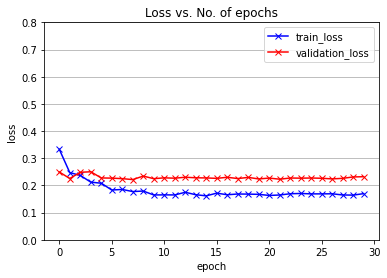

In [12]:
#plotting results
plt.figure(figsize=(15,10))
plt.plot(t_losses, 'b-x', label='train_loss')
plt.plot(v_losses, 'r-x', label='validation_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(axis='y')
plt.legend()
plt.ylim([0, .8])
plt.title('Loss vs. No. of epochs')
plt.savefig( path_graph + save_name + '.png')

In [23]:
#saving the loss plot 
def nump(lista):
  a = [n.cpu() for n in lista]
  b = [n.numpy() for n in a]
  c = [float('{:.5f}'.format(n)) for n in b]
  return c

tn_acc = nump(t_acc)
vn_acc = nump(v_acc)

df = pd.DataFrame({'epoch': range(30), 't_loss': t_losses, 'v_loss': v_losses, 't_acc': tn_acc, 'v_acc': vn_acc})

df.to_csv(path_pd + save_name + '_loss')

In [13]:
#using the best model 
model = torch.load(path_model + save_name + '_acc.pth', map_location=device)

In [ ]:
#prediction on test/saving pred.
true_labels = []
preds       = []
model.eval()
with torch.no_grad():
  for images, labels in test_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    logits = model(images)    
      
    curr_preds = torch.argmax(F.softmax(logits, dim=-1), dim=-1)
    true_labels.extend(labels.view(-1).tolist())
    preds.extend(curr_preds.view(-1).tolist())
print('{}classification report'.format(classification_report(true_labels, preds)))
report = classification_report(true_labels, preds, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv(path_pd + save_name + '_report')

In [ ]:
def imshow(inp, title=None):
   #imshow for tensor
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(3,3))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
#function for qualitative test
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if classes[preds[j]] == classes[labels[j]]:
                  images_so_far += 1
                  ax = plt.subplot(num_images//2, 2, images_so_far)
                  ax.axis('off')
                  ax.set_title(f'predicted: {classes[preds[j]]}\nlabel: {classes[labels[j]]}')
                  imshow(inputs.cpu().data[j].permute(0,2,1))
                else: continue

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [ ]:
visualize_model(model)